# Objective
With this project I'm going to classify the local cars according to their make based on the provided images

## Goals
- Get above 0.8 accuracy level
- Further test augmentation technics as the dataset is rather limited
- Test lighter EfficientNet model to accelerate the transfer learning

## About the data set
- 50k raw jpeg pics separated into 10 classes
- test.csv list with paths to the pictures that needs to be labeled

### Setting up the environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/ColabNotebooks/CarClassification/mds-misis-dl-car-classificationn/'

In [ ]:
import numpy as np
import pandas as pd




In [ ]:
import os

## Loading the data

In [ ]:
train_df=pd.read_csv(PATH +'train.csv')

In [ ]:
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [ ]:
# Setting up the parameters to use for training

EPOCHS               = 25  # epochs for training
BATCH_SIZE           = 32 # reduce the batch if the network is large, otherwise it will not fit in the memory on the GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # percent allocate data for test = 15%

RANDOM_SEED          = 42
CLASS_NUM            = 10  # the number of classes in our task
IMG_SIZE             = 224 # images size which we send to network
IMG_CHANNELS         = 3   # RGB gas 3 channels
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)




In [ ]:
sample_submission = pd.read_csv(PATH+"sample-submission.csv")

### Visual exploration

Пример картинок (random sample)
(640, 480)
(640, 360)
(640, 480)
(640, 360)
(640, 480)
(640, 480)
(640, 480)
(640, 480)
(640, 360)


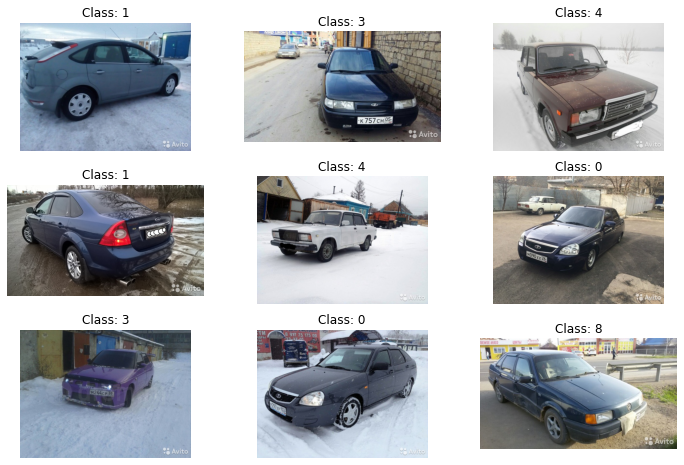

In [ ]:

import matplotlib.pyplot as plt
import PIL
from PIL import ImageOps, ImageFilter
#Lets increase the default size of the charts

print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'/train/train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
    print(im.size)
plt.show()

In [ ]:
# Preparing the parameters for further augmentation
horizontal_flip=True
vertical_flip=False
rotation_range=10
shear_range=0.1
brightness_range=(0.8, 1.6)
height_shift_range=0.1
width_shift_range=0.1
rescale=1
fill_mode='wrap'  #('nearest' is default, 'reflect', 'wrap')
zoom_range=[0.88,1.2]

In [ ]:
from keras.preprocessing.image import ImageDataGenerator


In [ ]:
train_datagen = ImageDataGenerator(
    # rescale=1. / 255,
    rotation_range=rotation_range,
    shear_range=shear_range,
    zoom_range=zoom_range,
    brightness_range=brightness_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=horizontal_flip)

val_datagen = ImageDataGenerator(validation_split=VAL_SPLIT)

sub_datagen = ImageDataGenerator()

In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'/train/train',      # the directory where the folders with pictures are located
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

val_generator = val_datagen.flow_from_directory(
    PATH+'train/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

sub_generator = sub_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test/test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)



Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


### Checking augmented pics

In [ ]:
import itertools
def show_first_images(generator, count=6, labels=True, figsize=(20, 5), normalized=False):
  generator = itertools.islice(generator, count)
  fig, axes = plt.subplots(nrows=1, ncols=count, figsize=figsize)
  for batch, ax in zip(generator, axes):
    if labels:
      img_batch, labels_batch = batch
      img, label = img_batch[0], np.argmax(labels_batch[0])
    else:
      img_batch = batch
      img = img_batch[0]
    if not normalized:
      img = img.astype(np.uint8)
    ax.imshow(img)
    if labels:
      ax.set_title(f'Class: {label}')
  plt.show()

Train:


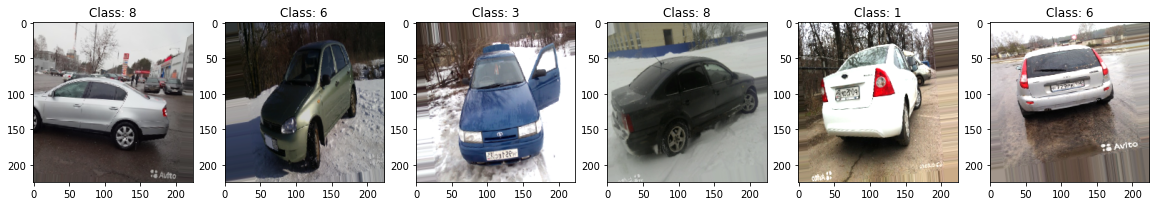

Val:


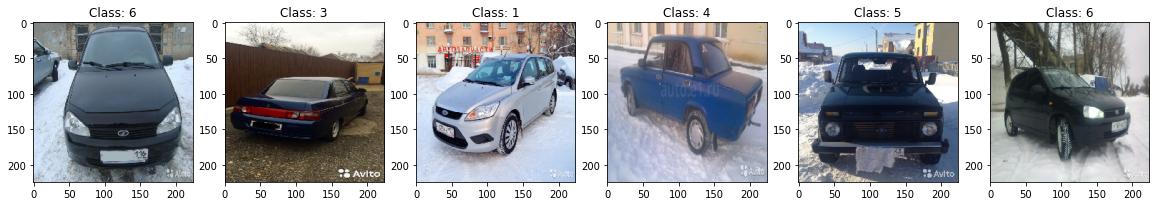

Sub:


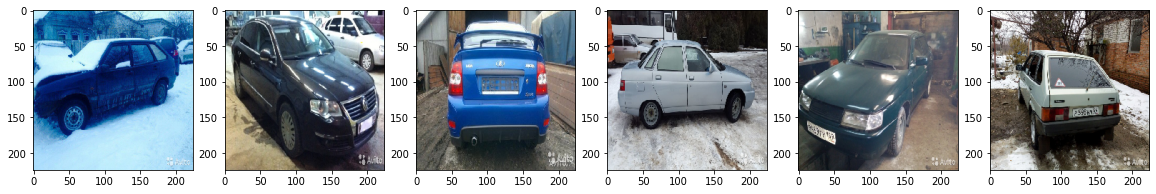

In [ ]:
print('Train:')
show_first_images(train_generator)

print('Val:')
show_first_images(val_generator)

print('Sub:')
show_first_images(sub_generator, labels=False)

### Building and training the model

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Using lighter EfficientNetB0 model as a backbone
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, GlobalMaxPool2D, Dense
model = Sequential([
  tf.keras.applications.EfficientNetB0(weights='imagenet', input_shape=(input_shape), include_top=False, classes=10, pooling='avg'), 
  Dense(10)
])




In [ ]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics='accuracy')

In [ ]:
from tensorflow.keras.callbacks import *

In [ ]:
checkpoint_path = '/content/drive/MyDrive/ColabNotebooks/CarClassification/model3.hdf5' #setting the path to write the best model

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

In [ ]:
history = model.fit(
        train_generator,
        validation_data = val_generator, 
        epochs = 30,
        callbacks=callbacks
)

Epoch 1/30
414/414 [==============================] - ETA: 0s - loss: 0.2012 - accuracy: 0.9282 
Epoch 1: val_loss improved from inf to 0.21579, saving model to /content/drive/MyDrive/ColabNotebooks/CarClassification/model3.hdf5
414/414 [==============================] - 4879s 12s/step - loss: 0.2012 - accuracy: 0.9282 - val_loss: 0.2158 - val_accuracy: 0.9287 - lr: 0.0010
Epoch 2/30
414/414 [==============================] - ETA: 0s - loss: 0.1770 - accuracy: 0.9352
Epoch 2: val_loss did not improve from 0.21579
414/414 [==============================] - 379s 915ms/step - loss: 0.1770 - accuracy: 0.9352 - val_loss: 0.2406 - val_accuracy: 0.9253 - lr: 0.0010
Epoch 3/30
414/414 [==============================] - ETA: 0s - loss: 0.1615 - accuracy: 0.9409
Epoch 3: val_loss did not improve from 0.21579
414/414 [==============================] - 372s 898ms/step - loss: 0.1615 - accuracy: 0.9409 - val_loss: 0.2493 - val_accuracy: 0.9124 - lr: 0.0010
Epoch 4/30
414/414 [======================

### Predicting and submitting the results

In [ ]:

predictions = model.predict(sub_generator, verbose=1)


209/209 [==============================] - 1567s 8s/step


In [ ]:
submission = pd.DataFrame({'Id': sub_generator.filenames, 'Category': predictions.argmax(axis = 1)})


In [ ]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,3
3,93598.jpg,7
4,87877.jpg,7


In [ ]:
submission.to_csv('/content/drive/MyDrive/ColabNotebooks/CarClassification/submission.csv', index = False)

### Result
The model achieved 0.96 accuracy for the test set which is far above the target of 0.8
